In [3]:
import os
import sys
import json
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

# Configuração para gráficos bonitos
plt.style.use('seaborn-v0_8-whitegrid')
mpl.rcParams['figure.figsize'] = (12, 6)
mpl.rcParams['lines.linewidth'] = 2
mpl.rcParams['axes.titlesize'] = 14
mpl.rcParams['axes.labelsize'] = 12

# Adiciona o caminho src ao path para importar módulos se necessário
# Ajuste '..' conforme onde você salvou o notebook
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
if project_root not in sys.path:
    sys.path.append(project_root)

# Definindo caminhos
DATA_DIR = os.path.join(project_root, "data", "output", "exp2", "curve_data")

print(f"Diretório de dados: {DATA_DIR}")

Diretório de dados: z:\02_SHK\05_dgl_gm\05_Scripts\rs_n_cm\data\output\exp2\curve_data


In [4]:
def load_json(filename):
    path = os.path.join(DATA_DIR, filename)
    if not os.path.exists(path):
        print(f"Arquivo não encontrado: {filename}")
        return None
    with open(path, 'r') as f:
        return json.load(f)

def extract_points(data):
    """Extrai X e Z dos dados (Assumindo perfil X-Z)."""
    if not data or 'points' not in data:
        return np.array([]), np.array([])
    
    pts = np.array(data['points'])
    # Se for Nx3 (X, Y, Z), pegamos X=0 e Z=2 (ou Z=1 se for 2D)
    if pts.shape[1] == 3:
        return pts[:, 0], pts[:, 2] # X e Z
    elif pts.shape[1] == 2:
        return pts[:, 0], pts[:, 1] # X e Y/Z
    return pts[:, 0], pts[:, 1]

def calculate_poly(x, coeffs):
    """Calcula Y/Z dado um vetor de coeficientes (polinômio)."""
    # np.polyval espera coeficientes do maior grau para o menor
    # Verifica se seus coeffs estão [a, b, c...] ou invertidos
    # O Fitter padrão do numpy (np.polyfit) retorna High->Low
    return np.polyval(coeffs, x)

Amostras encontradas: ['1', '2', '3', '4', '5', '6']


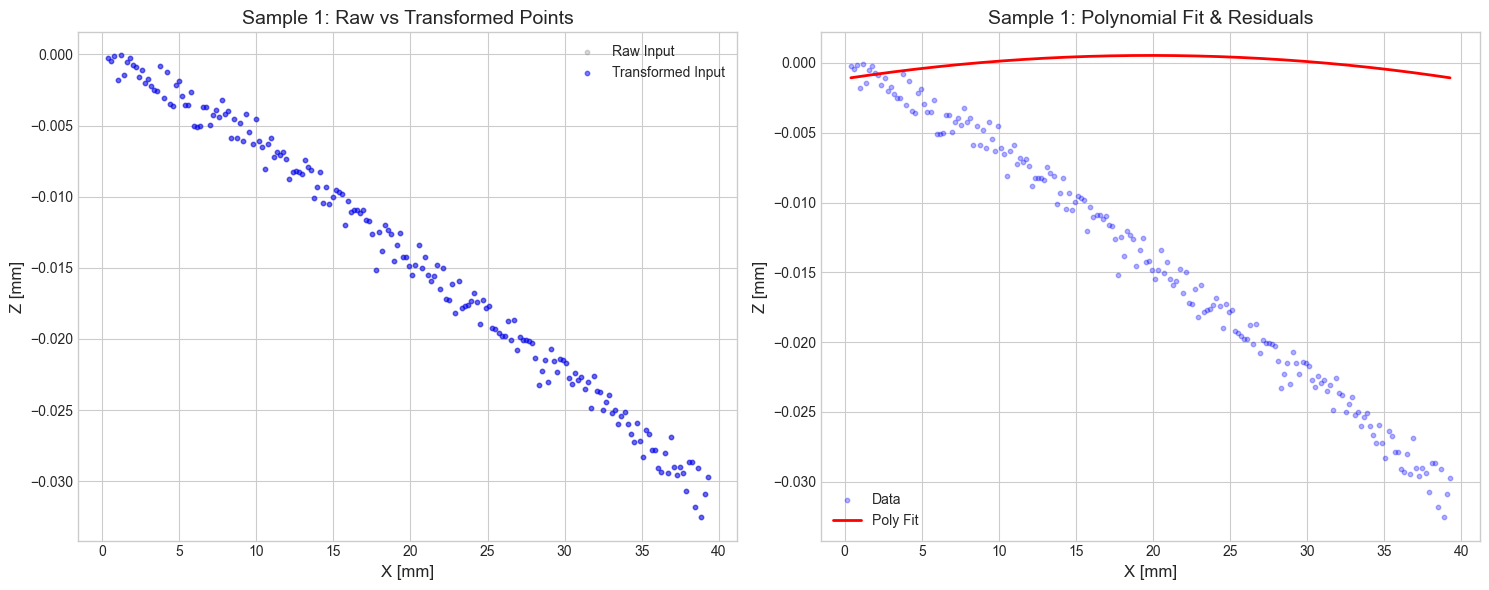

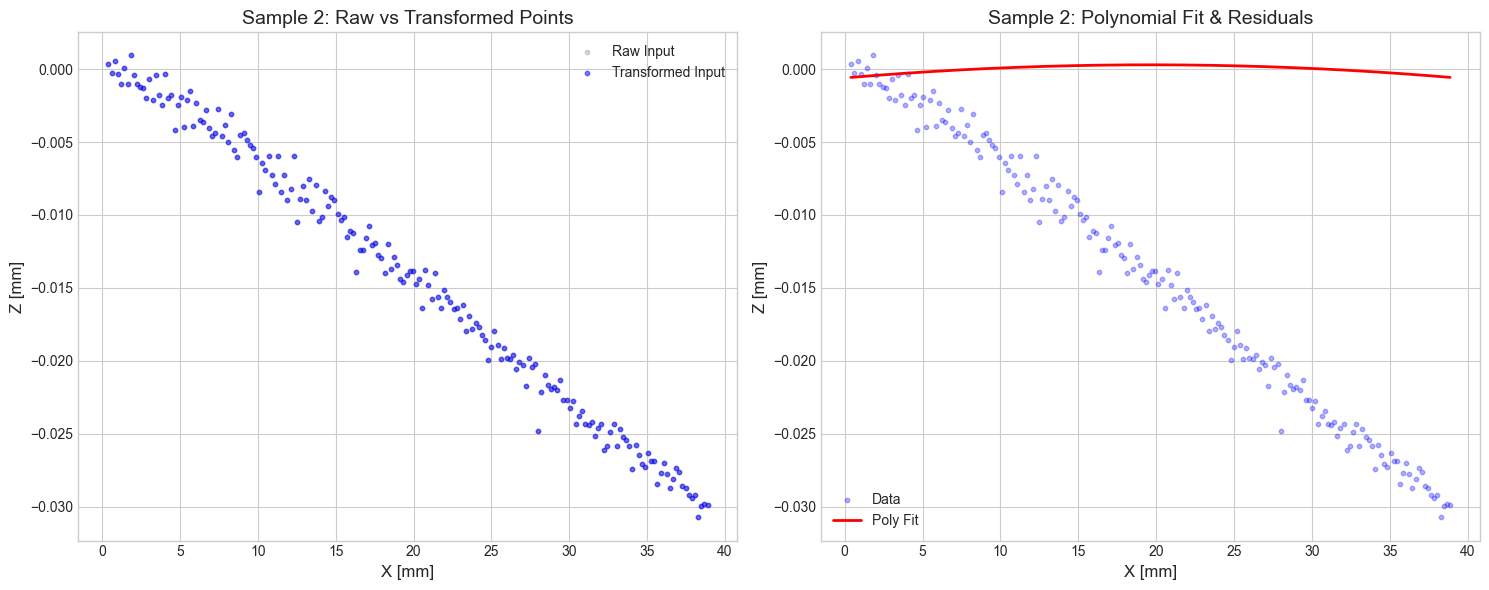

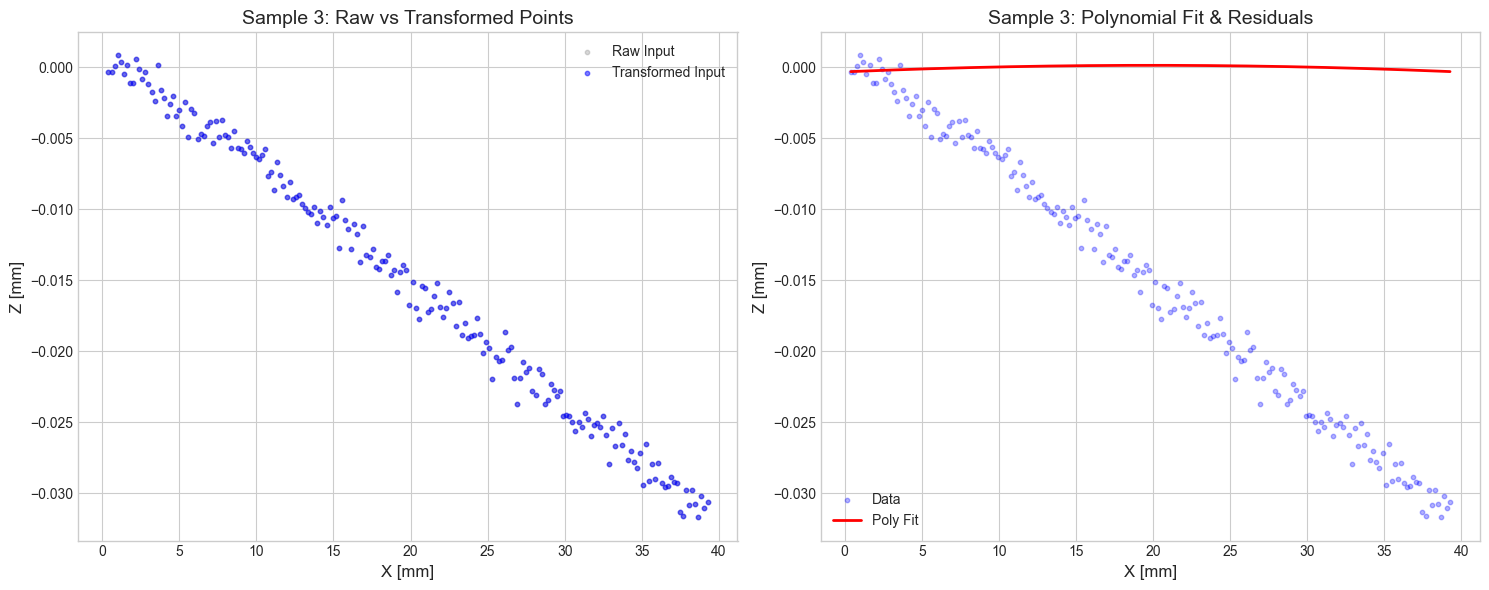

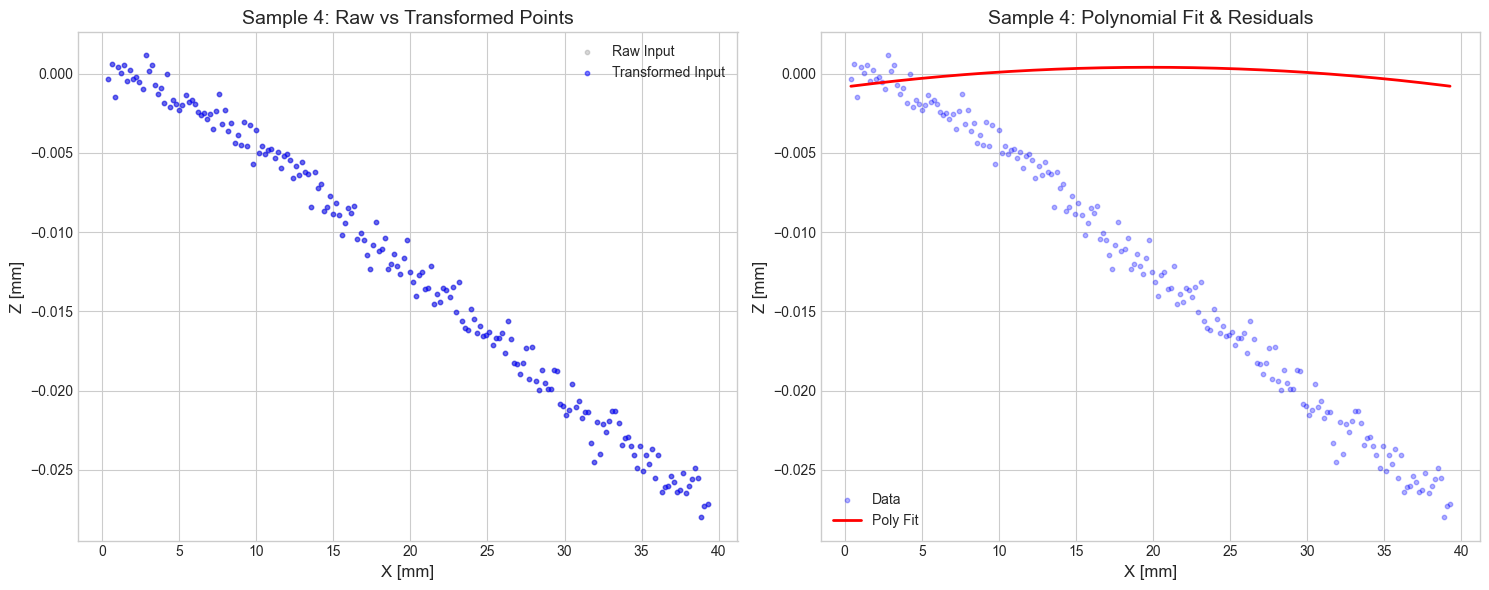

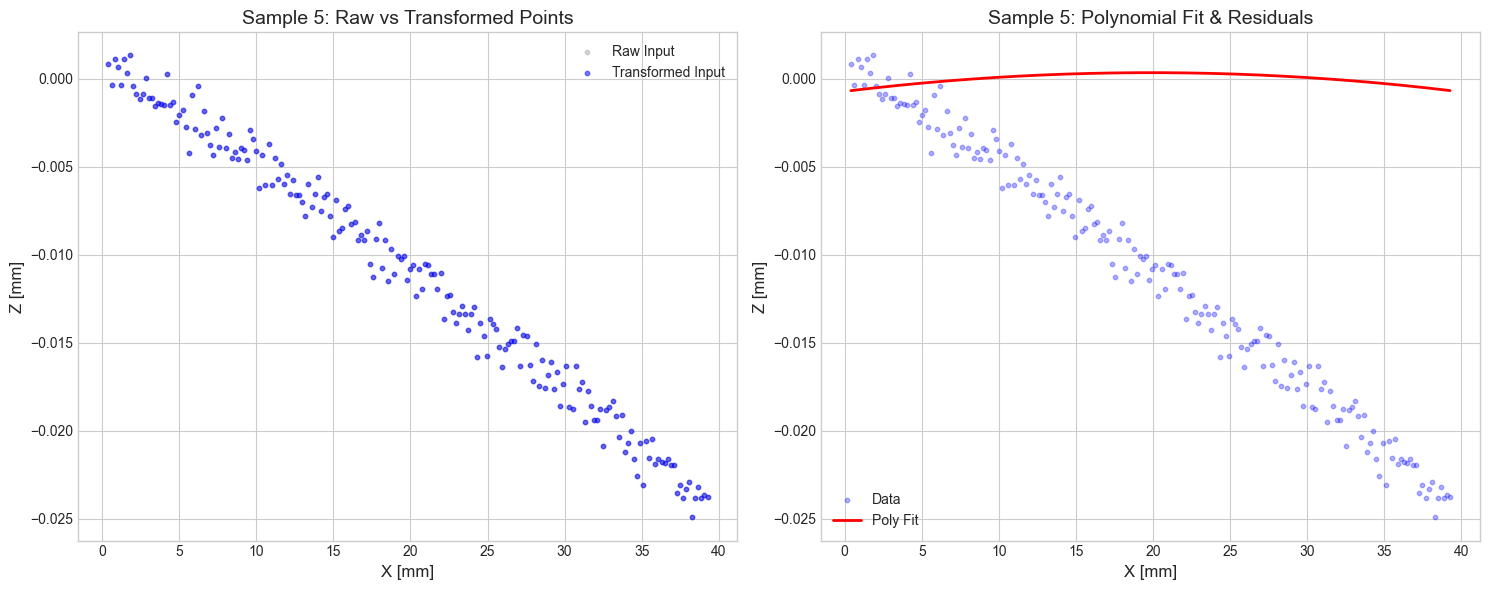

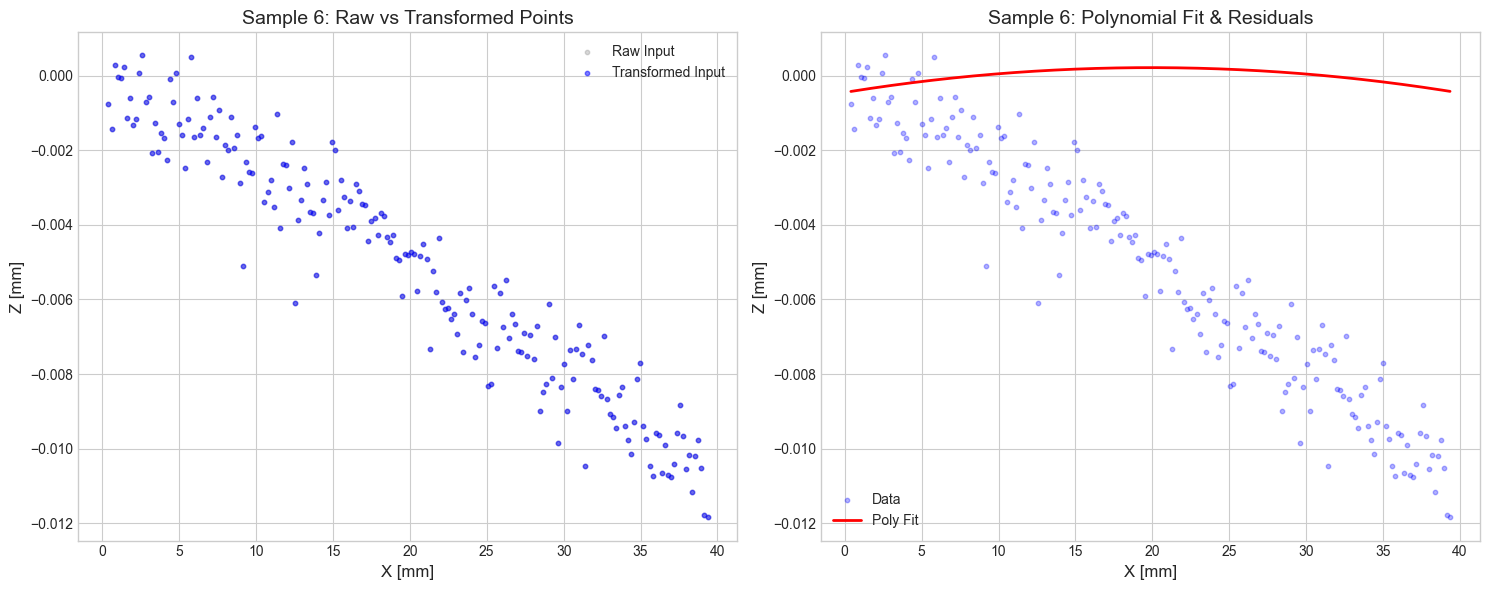

In [44]:
def plot_sample_fit(sample_id):
    raw_file = f"{sample_id}_Raw.json"
    processed_file = f"{sample_id}.json"
    
    raw_data = load_json(raw_file)
    proc_data = load_json(processed_file)
    
    if not raw_data or not proc_data:
        return

    # Extrair pontos
    xr, zr = extract_points(raw_data)
    xp, zp = extract_points(proc_data) # Pontos processados (transformados/espelhados)
    
    coeffs = proc_data.get('coeffs', [])
    
    fig, ax = plt.subplots(1, 2, figsize=(15, 6))
    
    # Plot 1: Dados Brutos vs Processados (Pontos)
    ax[0].set_title(f"Sample {sample_id}: Raw vs Transformed Points")
    ax[0].scatter(xr, zr, alpha=0.3, label='Raw Input', s=10, c='gray')
    ax[0].scatter(xp, zp, alpha=0.5, label='Transformed Input', s=10, c='blue')
    ax[0].set_xlabel("X [mm]")
    ax[0].set_ylabel("Z [mm]")
    ax[0].legend()
    
    # Plot 2: Ajuste Polinomial (Fit)
    # Gera linha suave para o polinômio
    x_line = np.linspace(min(xp), max(xp), 500)
    z_line = calculate_poly(x_line, coeffs) if coeffs else np.zeros_like(x_line)
    
    ax[1].set_title(f"Sample {sample_id}: Polynomial Fit & Residuals")
    ax[1].scatter(xp, zp, alpha=0.3, label='Data', s=10, c='blue')
    ax[1].plot(x_line, z_line, 'r-', label=f'Poly Fit', linewidth=2)
    
    # Opcional: Plotar curva "Ideal" (Tendência removida) se existir lógica para isso
    
    ax[1].set_xlabel("X [mm]")
    ax[1].set_ylabel("Z [mm]")
    ax[1].legend()
    
    plt.tight_layout()
    plt.show()

# Listar amostras disponíveis
files = [f for f in os.listdir(DATA_DIR) if f.endswith('_Raw.json')]
sample_ids = [f.split('_')[0] for f in files]

print(f"Amostras encontradas: {sample_ids}")

# Plotar todas (ou mude para plot_sample_fit('1'))
for sid in sample_ids:
    plot_sample_fit(sid)

Lendo curvas em: z:\02_SHK\05_dgl_gm\05_Scripts\rs_n_cm\data\output\exp2\curve_data


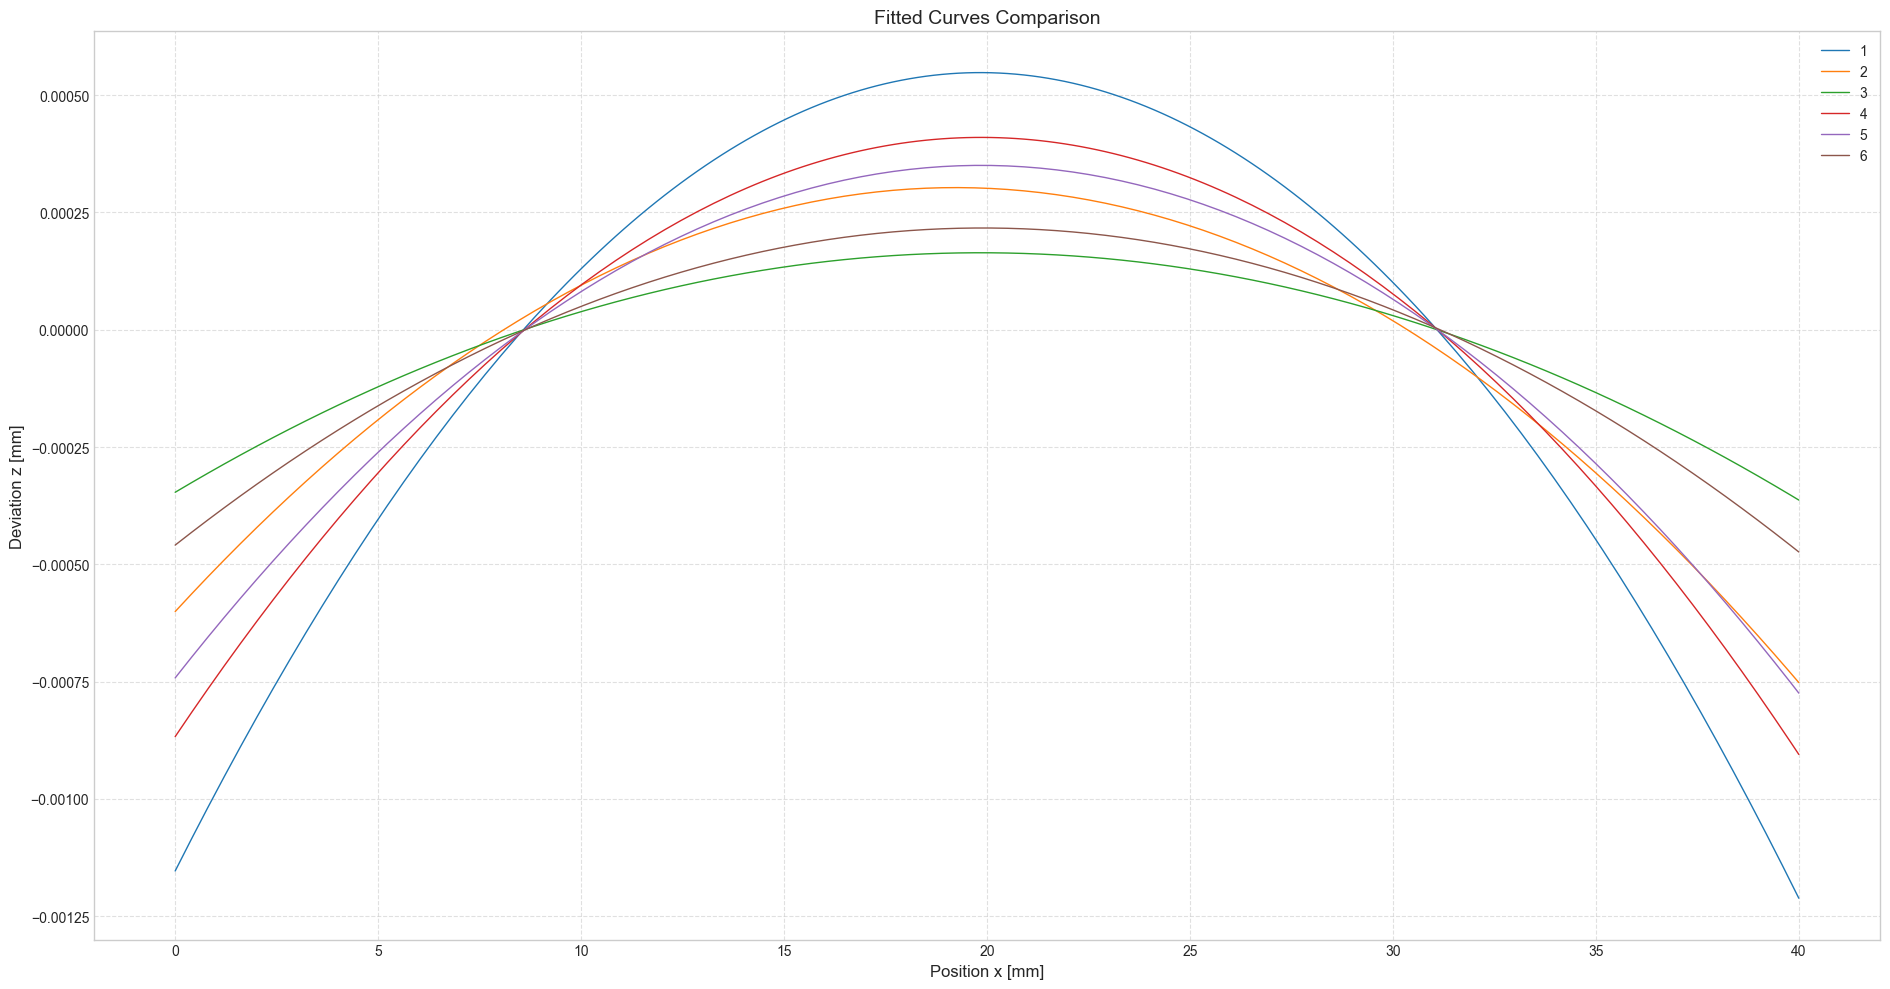

In [71]:
import os
import glob
import json
import numpy as np
import matplotlib.pyplot as plt

# --- 1. Configuração de Diretórios ---
# Tenta localizar a raiz do projeto automaticamente (subindo um nível se estiver em 'notebooks')
current_dir = os.getcwd()
if os.path.basename(current_dir) in ['notebook', 'notebooks']:
    project_root = os.path.dirname(current_dir)
else:
    project_root = current_dir

# Caminho onde os JSONs do exp2 foram salvos
curves_dir = os.path.join(project_root, "data", "output", "exp2", "curve_data")

# --- 2. Configuração do Plot ---
# Ajuste o range (0 a 40) conforme o tamanho real da sua amostra
xs = np.linspace(0, 40, 200) 

plt.figure(figsize=(19, 10))
lines = []

print(f"Lendo curvas em: {curves_dir}")

# Busca todos os JSONs
search_pattern = os.path.join(curves_dir, "*.json")
all_files = glob.glob(search_pattern)

for fp in all_files:
    filename = os.path.basename(fp)
    
    # Filtra arquivos auxiliares para plotar apenas as curvas finais/médias
    if "_Raw" in filename or "_Steps" in filename:
        continue
        
    with open(fp, 'r') as f:
        data = json.load(f)
    
    # O novo código salva como 'coeffs', mas mantive compatibilidade com 'params' se houver
    coeffs = data.get("coeffs") or data.get("params")
    
    if coeffs:
        # NOTA: O novo fitter.py gera coeficientes na ordem decrescente (padrão numpy).
        # Por isso usamos np.polyval em vez do loop manual antigo.
        ys = np.polyval(coeffs, xs)
        
        # Remove a extensão para usar como label
        label_name = os.path.splitext(filename)[0]
        
        line, = plt.plot(xs, ys, label=label_name, linewidth=1)
        lines.append(line)

# --- 3. Finalização ---
if lines:
    plt.legend()
    plt.xlabel("Position x [mm]")
    plt.ylabel("Deviation z [mm]")
    plt.title("Fitted Curves Comparison")
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()
else:
    print("Nenhum arquivo JSON de curva encontrado.")